# Get Geographical Data of Every German County
Read the file ["Readme.ipynb"](Readme.ipynb) for more information.

## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to convert the json from the API into a Python list
from json2xml.utils import readfromurl
# Used to cast the polygons into np.arrays to transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
import json    # to save the data in "json"-format in a file
# Used to check if their is a local file with the data or if a new API pull is inevitable
import os.path

## Control
Set variables to "True" to trigger the action described by the comment and the name of the variable.

In [2]:
# decides whether a new pull from the API is made or if a local backup should be used
counties_geography_new_pull_from_api = False
plot_unpolished_counties_geography_for_rough_overview = False    # takes approximately 2 minutes longer
show_examples_for_helper_functions = False
plot_polished_counties_geography_for_rough_overview = False      # takes approximately 2 minutes longer

The 102 counties must be checked by the user by having the program draw them.
If all counties have been checked and the plots are not needed anymore,
max_number_of_counties_to_plot can be set to zero to save some time.

In [3]:
max_number_of_counties_to_plot = 0

The variable "no_outputs_from_file_get_shapes_of_german_counties" can be set from the file executing this one.
If it is set to "True", all variables which create output to monitor the data are set to "False" and no output is generated.

In [4]:
try:
    no_outputs_from_file_get_shapes_of_german_counties
except NameError:
    no_outputs_from_file_get_shapes_of_german_counties = False

if no_outputs_from_file_get_shapes_of_german_counties:
    plot_unpolished_counties_geography_for_rough_overview = False
    show_examples_for_helper_functions = False
    max_number_of_counties_to_plot = 0
    plot_polished_counties_geography_for_rough_overview = False

The variable "number_of_counties" is also set here: It determines how many counties must be present in the data. If there are fewer or more, the current data source is declared a fail and (if possible) another one is used. It could also be set from the file calling this one, the try-except-construct exists for this purpose.

In [5]:
try:
    number_of_counties
except NameError:
    number_of_counties = 412

### Check the Controls
Check if the necessary files exist, otherwise the data must be taken from somewhere else (in this case from the API).

In [6]:
if not(os.path.isfile("unpolished_data/german_counties_geography.txt")):
    counties_geography_new_pull_from_api = True

## Get the Data and Save it in a File
### Pull the Data from the API
A pull from the ["COVID-19 Datenhub"](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0?geometry=-30.805%2C46.211%2C52.823%2C55.839) is initiated if "counties_geography_new_pull_from_api" is set to "True" or if "pulling" from the local backup of an old API-pull is not possible because of missing data. 
<br/>
<br/>
The program raises an error and "pulls" from a local backup of the API if the data does not contain as many counties as requested in the variable "number_of_counties".
<br/>
<br/>
If the unpolished data passes this rudimentary test, it is stored as it is in the file "german_counties_geography.txt" in the folder "unpolished_data". If the folder or the file does not yet exist, it is created.<br/>
This file can be used in further executions as a local backup of the API-pull.

In [7]:
if counties_geography_new_pull_from_api:
    # get the data - the url is kept in this long format to easily copy and check it manually
    counties_geography_raw = readfromurl("https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_Landkreisdaten/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json")
    # data is maybe faulty: if so report to user and use local backup of old API pull
    if len(counties_geography_raw["features"]) != number_of_counties:
        counties_geography_new_pull_from_api = False
        print("The provided data from the API does not have the preset number of counties of" +
        "{}, it has {}.".format(number_of_counties, len(counties_geography_raw["features"])))
    else:    # data seems to be fine: continue
        # check if the needed directory is available - otherwise create it
        if not(os.path.isdir("unpolished_data")): os.makedirs("unpolished_data")
        with open("unpolished_data/german_counties_geography.txt", "w") as file:
            file.write(json.dumps(counties_geography_raw))
        print("Data directly from API is ready to go!")

### "Pull" the Data from the Local API Backup
If the use of the data from a local backup of the API-pull is requested and possible,
the data from a local backup of an old API pull is used.
<br/>
The data from the backup is provided without further tests.

In [8]:
if not(counties_geography_new_pull_from_api):
    with open("unpolished_data/german_counties_geography.txt", "r") as file:
        counties_geography_raw = json.loads(file.read())
    print("Data from old API-pull is ready to go!")

Data from old API-pull is ready to go!


## Draw the Counties
Draw the raw data from the API pull or the backup to roughly check that no county is missing.

In [9]:
if plot_unpolished_counties_geography_for_rough_overview:
    plt.figure(figsize=(20, 20))    # enlarge plot
    # put all shapes into the plot
    for county in counties_geography_raw['features']:
        for polygon in county['geometry']['rings']:
            x, y = np.array(polygon).T
            plt.fill(x, y)
    plt.show()    # draw plot

## Initiate Polished Version and Find the Counties with Multiple Polygons
In the following, the required data is saved in the variable "counties_geography" and unnecessary dictionary shells are discarded.
<br/>
The separation of counties with multiple and single polygons is done simultaneously to save yourself the effort of another check of all counties.<br/>
A county with multiple polygons could have enclaves, cutouts, islands or something else. Therefore its index is saved to have it checked later on by the user. The other counties do not need to be checked and their index is not saved.
<br/>
### Extract Necessary Data
The data inside the dictionary "counties_geography_raw" is hard to reach and contains unnecessary information. Therefore the new dictionary "counties_geography" collects the following keys and the following kind of data (all packaged in a dictionary reachable through the AdmUnitID of a county):
   - name: Name of the county
   - population: Number of inhabitants from the last official estimate (varies, therefore check out the ["COVID-19 Datenhub"](https://npgeo-corona-npgeo-de.hub.arcgis.com/) for more information). These numbers are also used in the official incidence calculations.
   - area_in_m2: Area of the county in square meters, cannot be calculated from the polygons stored in geometry.
   - geometry: The shape of the county stored as one or more polygons. They also determine the position of the county on the map.
   - raw_geometry: The original version of the geometry used to draw the outlines of the counties.
<br/>

### Find the Counties with Multiple Polygons
The index of all counties which consist of multiple polygons are stored in the variable "index_of_counties_with_multiple_polygons".
<br/><br/>
Visualization of the reference and copy properties in Python (delete the hashtags before the print statements to generate output):

In [10]:
a = [1, 2, 3]
backup_of_a = a
a[1] = 5    # destroys the backup
# print(a, backup_of_a)
a = list()    # sets a new reference
# print(a, backup_of_a)

Since the polygons are by far the biggest part of the data, we only want to duplicate them if necessary. That is why they are only referenced and are only copied when they are modified.
<br/>
This option, which is a bit risky but more efficient, is chosen because the original data
is also backupped as a whole in "unpolished_data/german_counties_geography.txt".

In [11]:
counties_geography = dict()
index_of_counties_with_multiple_polygons = list()
for county in counties_geography_raw['features']:
    # convert the AdmUnitId to a string to keep uniformity:
    # after saving and loading from a file all keys are strings
    AdmUnitId = str(county['attributes']['AdmUnitId'])
    counties_geography[AdmUnitId] = dict(
        name = county['attributes']['county'],
        population = county['attributes']['EWZ'],
        area_in_m2 = county['attributes']['Shape__Area'],
        # referencing the original polygons -
        # cf. "Visualization of the reference and copy properties" further above
        geometry = county['geometry']['rings'],
        raw_geometry = county['geometry']['rings']
    )
    # store the index of every county with more than one polygon
    if len(county['geometry']['rings']) > 1:
        index_of_counties_with_multiple_polygons.append(AdmUnitId)

## Calculate the Population Density
The population density is calculated by dividing the population number by the area in square meters. In order to scale it to kilometers, the result is multiplied by 1,000,000.<br/>
The final result is stored in the dictionary "counties_geography".

In [12]:
for county in counties_geography.values():
    county["population_density"] = (county['population'] * 1000000)/county['area_in_m2']

13807.026922920515
853.3086670550518
35.601456035253875


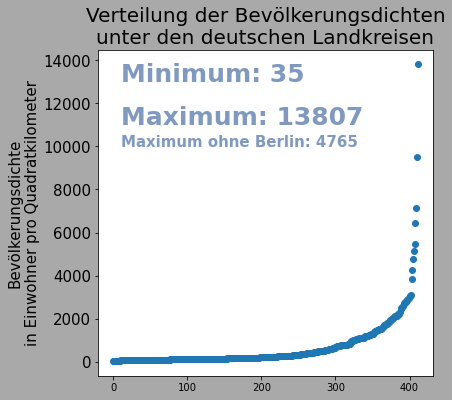

In [197]:
plt.figure(figsize=(6, 6), facecolor='darkgrey')    # enlarge plot
population_densities = list()
for AdmUnitId, county in counties_geography.items():
    population_densities.append(county["population_density"])
population_densities.sort()
print(population_densities[-1])
print(population_densities[320])
print(population_densities[0])
plt.title("Verteilung der Bevölkerungsdichten\nunter den deutschen Landkreisen",
         fontsize=20)
plt.ylabel("Bevölkerungsdichte\nin Einwohner pro Quadratkilometer",
         fontsize=15)
plt.yticks(fontsize=15)
plt.text(10, 13000, "Minimum: " + str(int(population_densities[0])),
         fontweight=1000, fontsize=25, color=(0.5, 0.6, 0.75))
plt.text(10, 11000, "Maximum: " + str(int(population_densities[-1])),
         fontweight=1000, fontsize=25, color=(0.5, 0.6, 0.75))
plt.text(10, 10000, "Maximum ohne Berlin: " + str(int(population_densities[-7])),
         fontweight=1000, fontsize=15, color=(0.5, 0.6, 0.75))
plt.scatter([i for i in range(len(population_densities))], population_densities)
plt.savefig("population_density_counties_distribution.png")

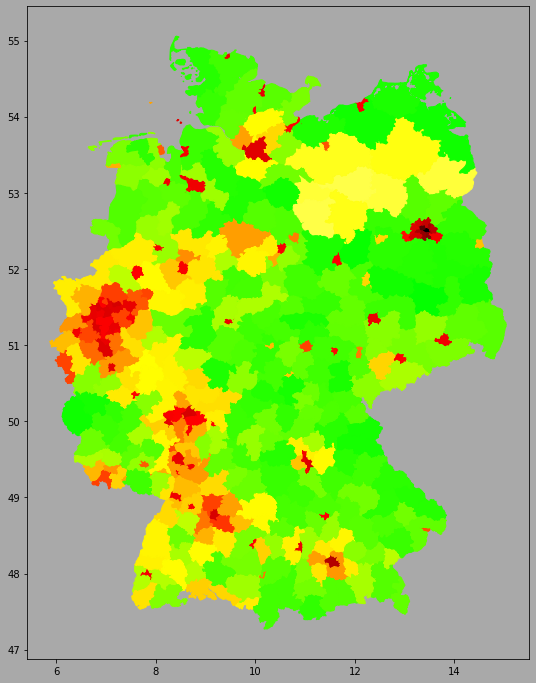

In [14]:
plt.figure(figsize=(9, 12), facecolor='darkgrey')    # enlarge plot
ax = plt.axes()
ax.set_facecolor('darkgrey')
for county in counties_geography.values():
    pop_density = county["population_density"]
    if pop_density > 1000:
        color = (1 - (pop_density-1000)/(population_densities[-1]-1000), 0, 0)
    elif pop_density > 200:
        color = (1, 1-(pop_density-200)/800, 0)
    elif pop_density > 50:
        color = ((pop_density-50)/200, 1, 0)
    else:
        color = (1, 1, 1-pop_density/50)

    for polygon in county['geometry']:
        x,y = np.array(polygon).T
        plt.fill(x, y, color=color)
plt.show()

In [129]:
districts = dict()
for AdmUnitId, county in counties_geography.items():
    district_id = AdmUnitId[:-2]
    # adding Berlin to the district of Potsdam
    if district_id == "110": district_id = "120"
    # adding Bremen and Bremerhaven to the district of Lüneburg
    if district_id == "40": district_id = "33"
    # adding Hamburg to the district of Lüneburg
    if district_id == "20": district_id = "33"
        
    if district_id not in districts.keys():
        districts[district_id] = list()
    districts[district_id].append(AdmUnitId)
pop_densities_districts = dict()
for district_id, counties_in_district in districts.items():
    district_pop_density = 0
    for AdmUnitId in counties_in_district:
        district_pop_density += counties_geography[AdmUnitId]["population_density"]
    pop_densities_districts[district_id] = district_pop_density//len(counties_in_district)

35
2299.0
207.0


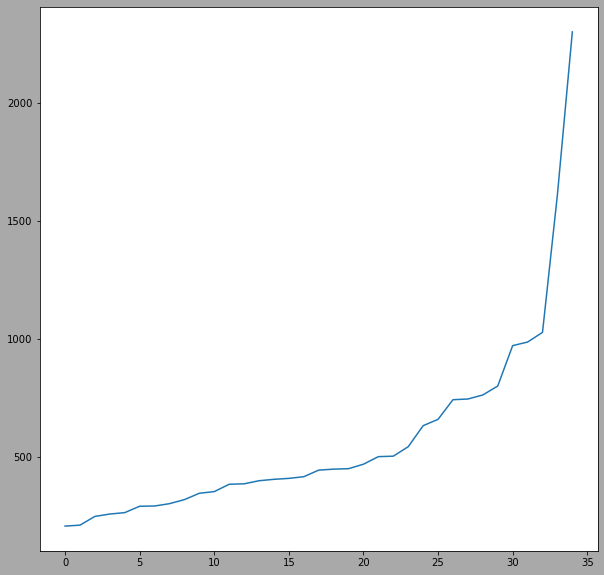

In [130]:
plt.figure(figsize=(10, 10), facecolor='darkgrey')    # enlarge plot
population_densities_districts = list(pop_densities_districts.values())
population_densities_districts.sort()
print(len(population_densities_districts))
print(population_densities_districts[-1])
print(population_densities_districts[0])
plt.plot(population_densities_districts)

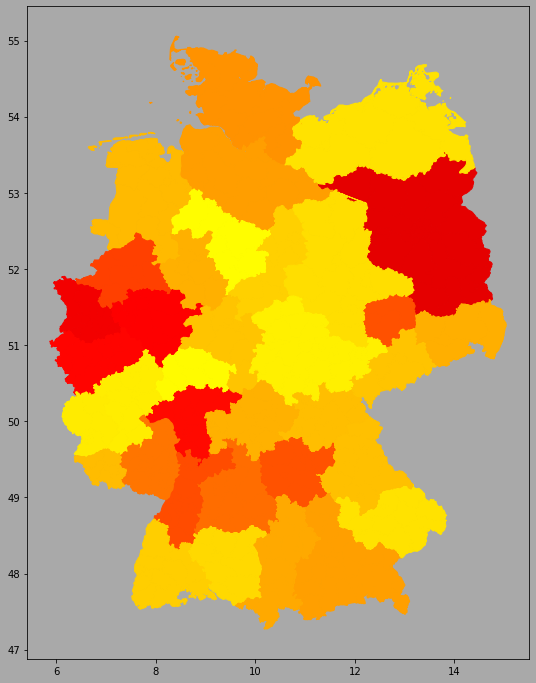

In [136]:
plt.figure(figsize=(9, 12), facecolor='darkgrey')    # enlarge plot
ax = plt.axes()
ax.set_facecolor('darkgrey')
for district, counties_in_district in districts.items():
    pop_density = pop_densities_districts[district]
    if pop_density > 1000:
        color = (1 - (pop_density-1000)/(population_densities[-1]-1000), 0, 0)
    elif pop_density > 200:
        color = (1, 1-(pop_density-200)/800, 0)
    elif pop_density > 50:
        color = ((pop_density-50)/200, 1, 0)
    else:
        color = (1, 1, 1-pop_density/50)

    for AdmUnitId in counties_in_district:
        for polygon in counties_geography[AdmUnitId]['geometry']:
            x,y = np.array(polygon).T
            plt.fill(x, y, color=color)
plt.show()

## Check the Counties with Multiple Polygons
### Helper Functions
If a county has more than one polygon stored as its shape, the user has to check whether the polygons are cutouts or real area.
Since the fastest way of doing this is by hand, there are five functions to support that.<br/>

**draw_polygon(polygon, plot_immediately, color)**: returns void (could show a plot)<br/>
*polygon*<br/>
-> shape of the polygon/county
<br/>
*plot_immediately* (default: True)<br/>
-> Determines whether "plt.show()" gets executed or not. If not, the plot will be drawn into one coordinate system with all other plots created in the same manner whenever plt.show() is called - allows to draw multiple polygons in one coordinate system.
<br/>
*plt_color* (default: None (standard color sequence))<br/>
-> sets the color of the polygon

In [18]:
def draw_polygon(polygon, plot_immediately = True, plt_color = None):
    x,y = np.array(polygon).T
    if plt_color:
        plt.fill(x, y, color = plt_color)
    else:
        plt.fill(x, y)
    if plot_immediately: plt.show()

In [19]:
if show_examples_for_helper_functions:
    print("all default: color by standard color scheme and plot immediately")
    draw_polygon([[1, 1], [1, 2], [2, 2], [2, 1]])

    print("change color to red ('r')")
    draw_polygon([[1, 1], [1, 2], [2, 2], [2, 1]], True, "r")

    print("change color to red ('r') and do not draw it")
    draw_polygon([[1, 1], [1, 2], [2, 2], [2, 1]], False, "r")
    print("seemingly cutout center of the red square from directly above " +
          "by using white as color and plot it")
    draw_polygon([[1.25, 1.25], [1.25, 1.75], [1.75, 1.75], [1.75, 1.25]], True, "w")

**draw_polygons(polygons, plot_single, plot_immediately , plt_color)**: returns void (could show multiple plots)<br/>
*polygons*<br/>
-> shapes of polygons/counties
<br/>
*plot_single* (default: False)<br/>
-> determines wether every polygon should be drawn in its own coordinate system or if all polygons should be accumulated in one
<br/>
*plot_immediately* (default: True)<br/>
-> Determines whether "plt.show()" gets executed in the end or not. If not, the plot(s) will be drawn into one coordinate system with all other plots created in the same manner whenever plt.show() is called - allows to draw multiple polygons in one coordinate system
<br/>
*plt_color* (default: None (standard color sequence))<br/>
-> sets the color of the polygons

In [20]:
def draw_polygons(polygons, plot_single = False, plot_immediately = True, plt_color = None):
    for polygon in polygons[:-1]:
        draw_polygon(polygon, plot_single, plt_color)
    if len(polygons):
        draw_polygon(polygons[-1], plot_immediately, plt_color)

In [21]:
if show_examples_for_helper_functions:
    print("Draw multiple polygons into one plot with the draw_polygons function:")
    draw_polygons([[[-1, 1], [-1, 2], [-2, 2], [-2, 1]],
                   [[1.25, 1.25], [1.25, 1.75], [1.75, 1.75], [1.75, 1.25]]],
                  False, True, "r")

**draw_polygons_of_county(AdmUnitId)**: returns void (could show polygons of given county)<br/>
*AdmUnitId*<br/>
-> identifier of the county whichs polygon(s) should be drawn

In [22]:
def draw_polygons_of_county(AdmUnitId):
    # max_number_of_counties_to_plot gets set at the begining of the file to execute faster
    global max_number_of_counties_to_plot
    if max_number_of_counties_to_plot >= 0:
        county = counties_geography[AdmUnitId]
        plt.rcParams["figure.figsize"]= (20, 20)    # enlarge plot
        # title of the plot
        plt.title("{} {} with {} polygons - check that your input is valid in the second plot!".format(
            AdmUnitId, county['name'], len(county['geometry'])))
        draw_polygons(county['geometry'])

**set_polygons_of_county(AdmUnitId, areas_or_cutouts_list)**: returns void (could show polygons of given county)<br/>
*AdmUnitId*<br/>
-> identifier of the county whichs polygon(s) should be modified and drawn.<br/>
*areas_or_cutouts_list* - same length as list of polygons related to this county, allows "add", "remove" or "exclude" as elements.<br/>
-> Determines which of the following actions should be taken:<br/>
<br/>
Executes the following for every polygon related to the county, determined by the keywords (highlighted by quotation marks) in the list "areas_or_cutouts_list":
- "add" the polygon to the list "counties_geography[AdmUnitID]['geometry']"
- "remove" the polygon/cut the polygon out of its predecessor in the polygon list "counties_geography[AdmUnitID]['geometry']"
  (this is done by adding it to the prior polygon and adding the last coordinate again,
  so technically there is a small slice cut out of the real area. This is only a problem when the outline is drawn, for this purpose the original geometry is saved in the list "counties_geography[AdmUnitID]['raw_geometry']")
- or simply "exclude" the polygon.

In [23]:
def set_polygons_of_county(AdmUnitId, areas_or_cutouts_list):
    county = counties_geography[AdmUnitId]

    # check if every polygon gets a value
    if len(county['geometry']) != len(areas_or_cutouts_list):
        raise Exception("lists of areas and cutouts and the polygon list" +
                        "do not have the same length: {} =/= {}".format(
        len(areas_or_cutouts_list), len(county['geometry'])))

    # create list to not destroy the backup
    # (explained in "Visualization of the reference and copy properties")
    new_county_geometry = list()

    # process user information:
    # - "add" to leave as is (for enclaves)
    # - "remove" to trade as cutout: add it to the prior polygon (not possible for first polygon)
    # - "exclude" to discard polygon
    for polygon_index in range(len(county['geometry'])):
        if areas_or_cutouts_list[polygon_index] == "add":
            new_county_geometry.append(county['geometry'][polygon_index].copy())
        elif areas_or_cutouts_list[polygon_index] == "remove" and polygon_index == 0:
            raise Exception("The first polygon cannot be cutout of its prior polygon" +
                            "because there is no prior polygon")
        elif areas_or_cutouts_list[polygon_index] == "remove":
            cutout = county['geometry'][polygon_index].copy() + [new_county_geometry[-1][-1]]
            new_county_geometry[-1] += cutout
        # nothing needs to be done if the command is "exclude",
        # but if the command is unknown an error is raised
        elif not(areas_or_cutouts_list[polygon_index] == "exclude"):
            raise Exception("The command {} is not known - use 'add', 'remove' or" +
                            "'exclude'".format(areas_or_cutouts_list[polygon_index]))

    county['geometry'] = new_county_geometry

    # draw to control
    draw_polygons_of_county(AdmUnitId)

**generator_index_of_counties_with_multiple_polygons()**: returns a generator to iterate over the collection of counties with multiple polygons

In [24]:
def generator_index_of_counties_with_multiple_polygons():
    for index_of_county_with_multiple_polygons in index_of_counties_with_multiple_polygons:
        global max_number_of_counties_to_plot
        max_number_of_counties_to_plot -= 1
        yield index_of_county_with_multiple_polygons
unchecked_counties = generator_index_of_counties_with_multiple_polygons()

### Check the Counties with Multiple Polygons
The user has to go through all the counties and determine whether in the "areas_or_cutouts_list" the area should be treated as area ("add") or cutout ("remove"). For irrelevant polygons "exclude" can be choosen.

In [25]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [26]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [27]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [28]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add"]*16)

In [29]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [30]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add", "add", "add", "add"])

In [31]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [32]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [33]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [34]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [35]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add"])

In [36]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [37]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [38]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [39]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [40]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [41]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [42]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add", "add", "add"])

In [43]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [44]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add"])

In [45]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [46]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [47]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [48]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [49]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [50]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [51]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [52]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add"])

In [53]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "add", "add"])

In [54]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [55]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [56]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [57]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [58]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [59]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [60]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [61]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [62]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [63]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [64]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [65]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [66]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [67]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [68]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [69]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "remove", "remove", "remove"])

In [70]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [71]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add"]*4 + ["remove"]*7)

In [72]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [73]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [74]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [75]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [76]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [77]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "remove"])

In [78]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove", "remove"])

In [79]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [80]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [81]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [82]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [83]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [84]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [85]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [86]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [87]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove", "remove"])

In [88]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [89]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [90]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [91]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [92]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [93]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [94]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [95]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [96]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [97]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [98]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [99]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [100]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [101]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [102]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [103]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [104]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [105]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [106]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [107]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [108]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [109]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [110]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [111]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add"]*37)

In [112]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add", "add", "remove", "remove"])

In [113]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add"]*21)

In [114]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [115]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [116]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [117]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [118]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [119]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [120]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove", "remove"])

In [121]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [122]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [123]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [124]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [125]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [126]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "remove"])

## Save the Polished Data in a File
The polished data is saved in the file "german_counties_geography.txt" in the folder "polished_data", inside the current directory. If the directory does not exist, it is created.

In [127]:
if not(os.path.isdir("polished_data")): os.makedirs("polished_data")
with open("polished_data/german_counties_geography.txt", "w") as file:
    file.write(json.dumps(counties_geography))

## Draw the Counties
Draw the polished data to roughly check that no county is missing.

In [128]:
if plot_polished_counties_geography_for_rough_overview:
    plt.figure(figsize = (20, 20))    # enlarge plot
    for county in counties_geography.values():
        for polygon in county['geometry']:
            x,y = np.array(polygon).T
            plt.fill(x, y)
    plt.show()